# 2023-03-01 Singular Value Decomposition

## Last time

* Householder QR
* Composition of reflectors

## Today

* Comparison of interfaces
* Profiling
* Cholesky QR
* Matrix norms and conditioning
* Geometry of the SVD

In [1]:
using LinearAlgebra
using Plots
default(linewidth=4, legendfontsize=12)

function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function gram_schmidt_classical(A)
    m, n = size(A)
    Q = zeros(m, n)
    R = zeros(n, n)
    for j in 1:n
        v = A[:,j]
        R[1:j-1,j] = Q[:,1:j-1]' * v
        v -= Q[:,1:j-1] * R[1:j-1,j]
        R[j,j] = norm(v)
        Q[:,j] = v / R[j,j]
    end
    Q, R
end

function qr_householder(A)
    m, n = size(A)
    R = copy(A)
    V = [] # list of reflectors
    for j in 1:n
        v = copy(R[j:end, j])
        v[1] += sign(v[1]) * norm(v) # <---
        v = normalize(v)
        R[j:end,j:end] -= 2 * v * v' * R[j:end,j:end]
        push!(V, v)
    end
    V, R
end

qr_householder (generic function with 1 method)

# Composition of reflectors

\begin{align}
(I - 2 v v^T) (I - 2 w w^T) &= I - 2 v v^T - 2 w w^T + 4 v (v^T w) w^T \\
&= I - \Bigg[v \Bigg| w \Bigg] \begin{bmatrix} 2 & -4 v^T w \\ 0 & 2 \end{bmatrix} \begin{bmatrix} v^T \\ w^T \end{bmatrix}
\end{align}

This turns applying reflectors from a sequence of vector operations to a sequence of (smallish) matrix operations. It's the key to high performance and the native format (`QRCompactWY`) returned by Julia `qr()`.

In [2]:
x = LinRange(-1, 1, 20)
A = vander(x)
Q, R = qr(A)
#norm(Q[:,1])

LinearAlgebra.QRCompactWY{Float64, Matrix{Float64}}
Q factor:
20×20 LinearAlgebra.QRCompactWYQ{Float64, Matrix{Float64}}:
 -0.223607  -0.368394   -0.430192    0.437609   …  -3.23545e-5   -5.31905e-6
 -0.223607  -0.329616   -0.294342    0.161225       0.000550027   0.000101062
 -0.223607  -0.290838   -0.173586   -0.0383868     -0.00436786   -0.000909558
 -0.223607  -0.252059   -0.067925   -0.170257       0.0214511     0.00515416
 -0.223607  -0.213281    0.0226417  -0.243417      -0.0726036    -0.0206167
 -0.223607  -0.174503    0.0981139  -0.266901   …   0.178209      0.06185
 -0.223607  -0.135724    0.158492   -0.24974       -0.323416     -0.144317
 -0.223607  -0.0969458   0.203775   -0.200966       0.429021      0.268016
 -0.223607  -0.0581675   0.233964   -0.129612      -0.386119     -0.402025
 -0.223607  -0.0193892   0.249058   -0.0447093      0.157308      0.491364
 -0.223607   0.0193892   0.249058    0.0447093  …   0.157308     -0.491364
 -0.223607   0.0581675   0.233964    0.1296

# This works even for very nonsquare matrices

In [6]:
A = rand(1000000, 5)
Q, R = qr(A)
@show size(Q)
@show norm(Q*R - A)
R
Q * vcat(zeros(1000000 - 3), [1,0,0])

size(Q) = (1000000, 1000000)
norm(Q * R - A) = 1.5627435002979355e-12


1000000-element Vector{Float64}:
 -0.000710716962490326
 -0.0006221486003295463
 -0.001481395515703071
  0.0006986145984357538
  0.00030719398438148966
 -3.7070273376922167e-6
 -1.846993064721867e-6
  5.892273227768894e-7
 -3.4792383435730715e-6
  2.2249702781554393e-6
 -1.8148213625435382e-6
 -1.3842243836198498e-8
 -2.943731575863994e-6
  ⋮
  5.4302791596705405e-8
 -1.2863812388719472e-6
 -3.1178852037441024e-6
 -1.454678366309665e-6
  1.129578508676748e-6
 -1.0958261567418687e-6
 -1.4438579316234545e-7
  4.451050785148942e-7
 -1.2256371019533118e-6
  0.9999963354732083
  4.843751131958308e-7
  2.761092851686931e-7

This is known as a "full" (or "complete") QR factorization, in contrast to a reduced QR factorization in which $Q$ has the same shape as $A$.
* How much memory does $Q$ use?

# Compare to [`numpy.linalg.qr`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.qr.html)

* Need to decide up-front whether you want full or reduced QR.
* Full QR is expensive to represent.

# Cholesky QR

$$ R^T R = (QR)^T QR = A^T A$$

so we should be able to use $L L^T = A^T A$ and then $Q = A L^{-T}$.

In [9]:
function qr_chol(A)
    R = cholesky(A' * A).U
    Q = A / R
    Q, R
end

A = rand(20,20)
Q, R = qr_chol(A)
@show norm(Q' * Q - I)
@show norm(Q * R - A)

norm(Q' * Q - I) = 1.3547676815713508e-13
norm(Q * R - A) = 1.289504394296693e-15


1.289504394296693e-15

In [14]:
x = LinRange(-1, 1, 20)
A = vander(x)
Q, R = qr_chol(A)
@show norm(Q' * Q - I)
@show norm(Q * R - A);

LoadError: PosDefException: matrix is not positive definite; Cholesky factorization failed.

# Can we fix this?

Note that the product of two triangular matrices is triangular.

In [43]:
R = triu(rand(5,5))
R * R

5×5 Matrix{Float64}:
 0.937018  0.166589  1.28394   0.856513  1.91001
 0.0       0.147171  0.422197  0.410025  1.03557
 0.0       0.0       0.466456  0.381229  0.947622
 0.0       0.0       0.0       0.690276  0.506928
 0.0       0.0       0.0       0.0       0.0989786

In [30]:
function qr_chol2(A)
    Q, R = qr_chol(A)
    Q, R1 = qr_chol(Q)
    Q, R1 * R
end

x = LinRange(-1, 1, 18)
A = vander(x)
Q, R = qr_chol2(A)
@show norm(Q' * Q - I)
@show norm(Q * R - A);

norm(Q' * Q - I) = 1.1333031064724956e-15
norm(Q * R - A) = 1.1896922215066695e-15


# How fast are these methods?

In [34]:
m, n = 5000, 2000
A = randn(m, n)

@time qr(A);

  1.507001 seconds (7 allocations: 77.393 MiB, 0.34% gc time)


In [35]:
A = randn(m, n)
@time qr_chol2(A);

  1.067684 seconds (21 allocations: 305.176 MiB, 0.90% gc time)


# Profiling

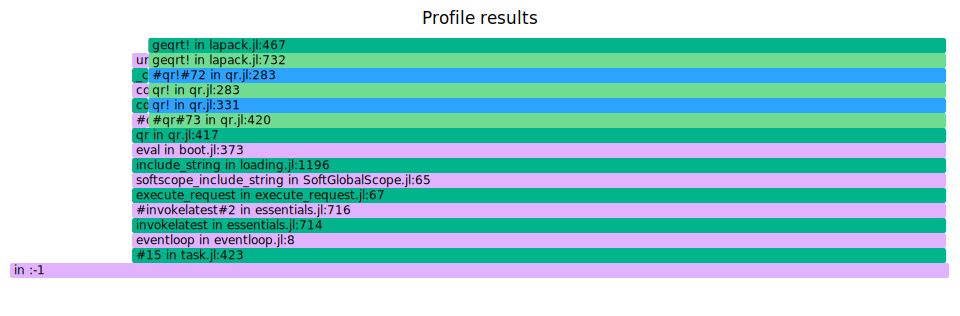

In [37]:
using ProfileSVG

@profview qr(A)

## Condition number of a matrix

We may have informally referred to a matrix as "ill-conditioned" when the columns are nearly linearly dependent, but let's make this concept for precise.  Recall the definition of (relative) condition number:

$$ \kappa = \max_{\delta x} \frac{|\delta f|/|f|}{|\delta x|/|x|} . $$

We understood this definition for scalar problems, but it also makes sense when the inputs and/or outputs are vectors (or matrices, etc.) and absolute value is replaced by vector (or matrix) norms.  Consider matrix-vector multiplication, for which $f(x) = A x$.

$$ \kappa(A) = \max_{\delta x} \frac{\lVert A (x+\delta x) - A x \rVert/\lVert A x \rVert}{\lVert \delta x\rVert/\lVert x \rVert}
= \max_{\delta x} \frac{\lVert A \delta x \rVert}{\lVert \delta x \rVert} \, \frac{\lVert x \rVert}{\lVert A x \rVert} = \lVert A \rVert \frac{\lVert x \rVert}{\lVert A x \rVert} . $$

There are two problems here:

* I wrote $\kappa(A)$ but my formula depends on $x$.
* What is that $\lVert A \rVert$ beastie?


## Matrix norms induced by vector norms

Vector norms are built into the linear space (and defined in term of the inner product).  Matrix norms are *induced* by vector norms, according to

$$ \lVert A \rVert = \max_{x \ne 0} \frac{\lVert A x \rVert}{\lVert x \rVert} . $$

* This equation makes sense for non-square matrices -- the vector norms of the input and output spaces may differ.
* Due to linearity, all that matters is direction of $x$, so it could equivalently be written

$$ \lVert A \rVert = \max_{\lVert x \rVert = 1} \lVert A x \rVert . $$


# The formula makes sense, but still depends on $x$.

$$\kappa(A) = \lVert A \rVert \frac{\lVert x \rVert}{\lVert Ax \rVert}$$

Consider the matrix

$$ A = \begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix} . $$

* What is the norm of this matrix?
* What is the condition number when $x = [1,0]^T$?
* What is the condition number when $x = [0,1]^T$?

## Condition number of the matrix

The condition number of matrix-vector multiplication depends on the vector.  The condition number of the matrix is the worst case (maximum) of the condition number for any vector, i.e.,

$$ \kappa(A) = \max_{x \ne 0} \lVert A \rVert \frac{\lVert x \rVert}{\lVert A x \rVert} .$$

If $A$ is invertible, then we can rephrase as

$$ \kappa(A) = \max_{x \ne 0} \lVert A \rVert \frac{\lVert A^{-1} (A x) \rVert}{\lVert A x \rVert} =
\max_{A x \ne 0} \lVert A \rVert \frac{\lVert A^{-1} (A x) \rVert}{\lVert A x \rVert} = \lVert A \rVert \lVert A^{-1} \rVert . $$

Evidently multiplying by a matrix is just as ill-conditioned of an operation as solving a linear system using that matrix.

## Least squares and the normal equations

A **least squares problem** takes the form: given an $m\times n$ matrix $A$ ($m \ge n$), find $x$ such that
$$ \lVert Ax - b \rVert $$
is minimized.  If $A$ is square and full rank, then this minimizer will satisfy $A x - b = 0$, but that is not the case in general because $b$ is not in the range of $A$.
The residual $A x - b$ must be orthogonal to the range of $A$.

* Is this the same as saying $A^T (A x - b) = 0$?
* If $QR = A$, is it the same as $Q^T (A x - b) = 0$?

In the quiz, we showed that $QQ^T$ is an orthogonal projector onto the range of $Q$.  If $QR = A$,
$$ QQ^T (A x - b) = QQ^T(Q R x - b) = Q (Q^T Q) R x - QQ^T b = QR x - QQ^T b = A x - QQ^T b . $$
So if $b$ is in the range of $A$, we can solve $A x = b$.  If not, we need only *orthogonally* project $b$ into the range of $A$.

### Solution by QR (Householder)

Solve $R x = Q^T b$.

* QR factorization costs $2 m n^2 - \frac 2 3 n^3$ operations and is done once per matrix $A$.
* Computing $Q^T b$ costs $4 (m-n)n + 2 n^2 = 4 mn - 2n^2$ (using the elementary reflectors, which are stable and lower storage than naive storage of $Q$).
* Solving with $R$ costs $n^2$ operations.  Total cost per right hand side is thus $4 m n - n^2$.

This method is stable and accurate.

### Solution by Cholesky

The mathematically equivalent form $(A^T A) x = A^T b$ are called the **normal equations**.  The solution process involves factoring the symmetric and positive definite $n\times n$ matrix $A^T A$.

* Computing $A^T A$ costs $m n^2$ flops, exploiting symmetry.
* Factoring $A^T A = R^T R$ costs $\frac 1 3 n^3$ flops.  The total factorization cost is thus $m n^2 + \frac 1 3 n^3$.
* Computing $A^T b$ costs $2 m n$.
* Solving with $R^T$ costs $n^2$.
* Solving with $R$ costs $n^2$.  Total cost per right hand side is thus $2 m n + 2 n^2$.

The product $A^T A$ is ill-conditioned: $\kappa(A^T A) = \kappa(A)^2$ and can reduce the accuracy of a least squares solution.

### Solution by Singular Value Decomposition

Next, we will discuss a factorization
$$ U \Sigma V^T = A $$
where $U$ and $V$ have orthonormal columns and $\Sigma$ is diagonal with nonnegative entries.
The entries of $\Sigma$ are called **singular values** and this decomposition is the **singular value decomposition** (SVD).
It may remind you of an eigenvalue decomposition $X \Lambda X^{-1} = A$, but
* the SVD exists for all matrices (including non-square and deficient matrices)
* $U,V$ have orthogonal columns (while $X$ can be arbitrarily ill-conditioned).
Indeed, if a matrix is symmetric and positive definite (all positive eigenvalues), then $U=V$ and $\Sigma = \Lambda$.
Computing an SVD requires a somewhat complicated iterative algorithm, but a crude estimate of the cost is $2 m n^2 + 11 n^3$.  Note that this is similar to the cost of $QR$ when $m \gg n$, but much more expensive for square matrices.
Solving with the SVD involves
* Compute $U^T b$ at a cost of $2 m n$.
* Solve with the diagonal $n\times n$ matrix $\Sigma$ at a cost of $n$.
* Apply $V$ at a cost of $2 n^2$.  The total cost per right hand side is thus $2 m n + 2n^2$.

# Activity: Geometry of the Singular Value Decomposition

In [38]:
default(aspect_ratio=:equal)

function peanut()
    theta = LinRange(0, 2*pi, 50)
    r = 1 .+ .4*sin.(3*theta) + .6*sin.(2*theta)
    r' .* [cos.(theta) sin.(theta)]'
end

function circle()
    theta = LinRange(0, 2*pi, 50)
    [cos.(theta) sin.(theta)]'
end

function Aplot(A)
    "Plot a transformation from X to Y"
    X = peanut()
    Y = A * X
    p = scatter(X[1,:], X[2,:], label="in")
    scatter!(p, Y[1,:], Y[2,:], label="out")
    X = circle()
    Y = A * X
    q = scatter(X[1,:], X[2,:], label="in")
    scatter!(q, Y[1,:], Y[2,:], label="out")
    plot(p, q, layout=2)
end

Aplot (generic function with 1 method)

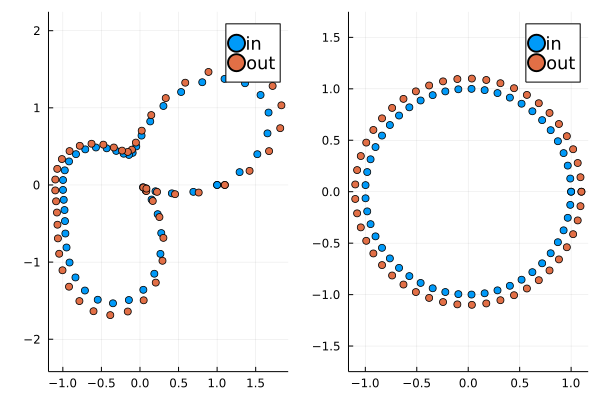

In [39]:
Aplot(1.1*I)

# Diagonal matrices

Perhaps the simplest transformation is a scalar multiple of the identity.


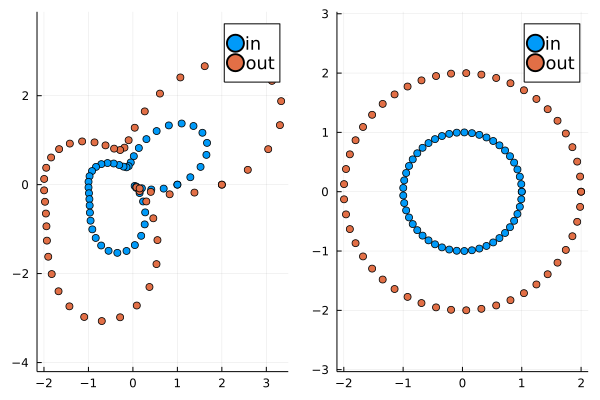

In [6]:
Aplot([2 0; 0 2])

The diagonal entries can be different sizes.

$$ A = \begin{bmatrix} 2 & 0 \\ 0 & .5 \end{bmatrix}$$

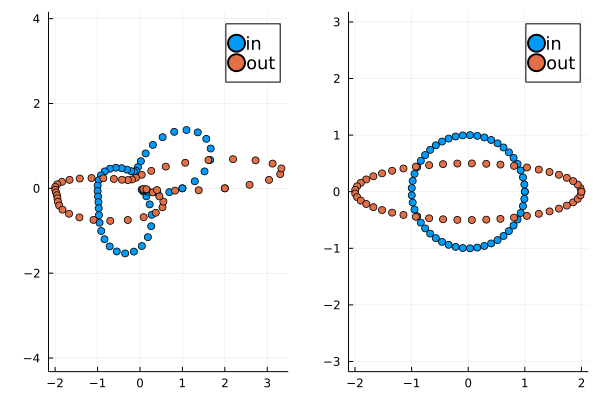

In [7]:
Aplot([2 0; 0 .5])

The circles becomes an **ellipse** that is **aligned with the coordinate axes**

# Givens Rotation (as example of orthogonal matrix)

We can rotate the input using a $2\times 2$ matrix, parametrized by $\theta$. Its transpose rotates in the opposite direction.


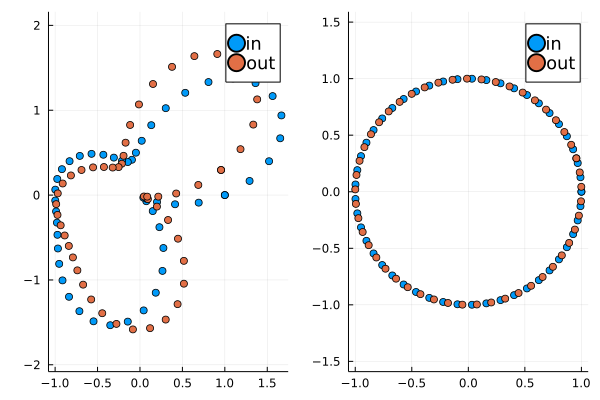

In [8]:
function givens(theta)
    s = sin(theta)
    c = cos(theta)
    [c -s; s c]
end

G = givens(0.3)
Aplot(G)

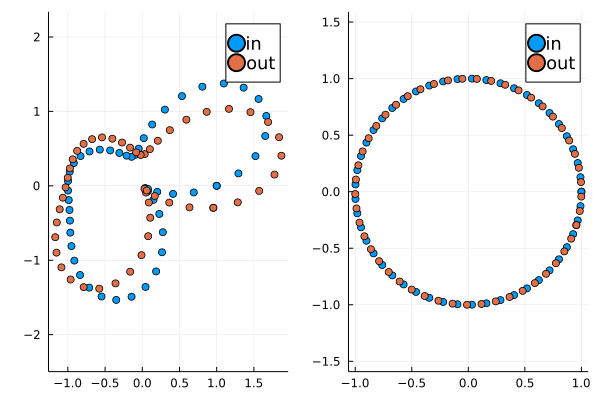

In [9]:
Aplot(G')

# Reflection

We've previously seen that reflectors have the form $F = I - 2 v v^T$ where $v$ is a normalized vector. Reflectors satisfy $F^T F = I$ and $F = F^T$, thus $F^2 = I$.

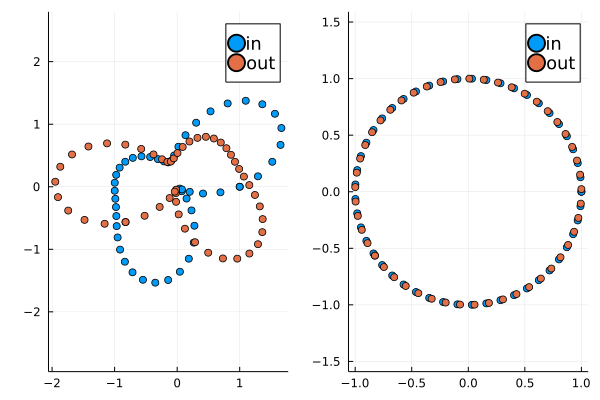

In [10]:
function reflect(theta)
    v = [cos(theta), sin(theta)]
    I - 2 * v * v'
end

Aplot(reflect(0.3))

# Singular Value Decomposition

The SVD is $A = U \Sigma V^T$ where $U$ and $V$ have orthonormal columns and $\Sigma$ is diagonal with nonnegative entries. It exists for any matrix (non-square, singular, etc.). If we think of orthogonal matrices as reflections/rotations, this says any matrix can be represented as reflect/rotate, diagonally scale, and reflect/rotate again.

Let's try a random symmetric matrix.

det(A) = -1.6820338013412035


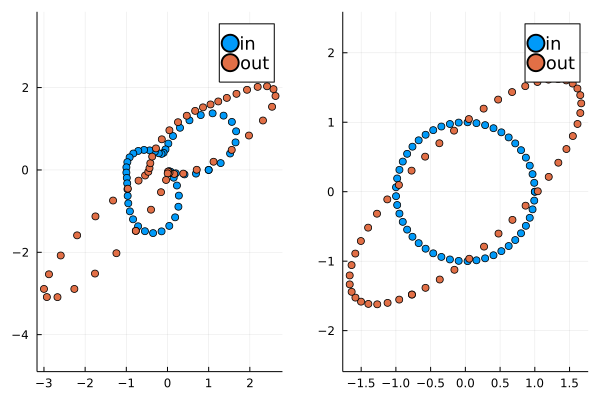

In [22]:
A = randn(2, 2)
A += A' # make symmetric
@show det(A) # Positive means orientation is preserved
Aplot(A)

norm(U * diagm(S) * V' - A) = 4.002966042486721e-16


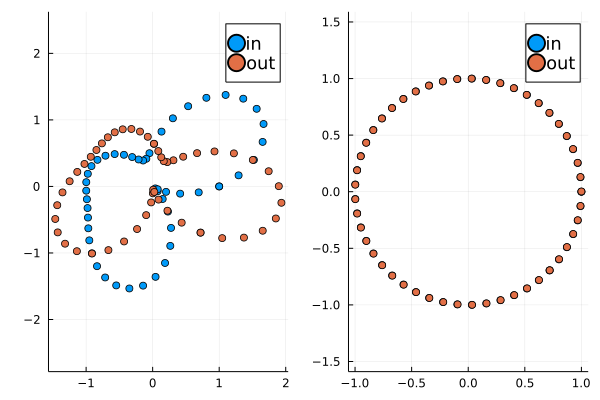

In [23]:
U, S, V = svd(A)
@show norm(U * diagm(S) * V' - A) # Should be zero
Aplot(V') # Rotate/reflect in preparation for scaling

* What visual features indicate that this is a symmetric matrix?
* Is the orthogonal matrix a reflection or rotation?
    * Does this change when the determinant is positive versus negative (rerun the cell above as needed).



# Parts of the SVD

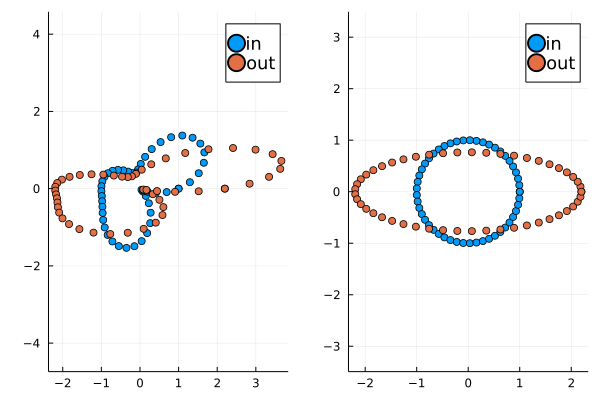

In [24]:
Aplot(diagm(S)) # scale along axes

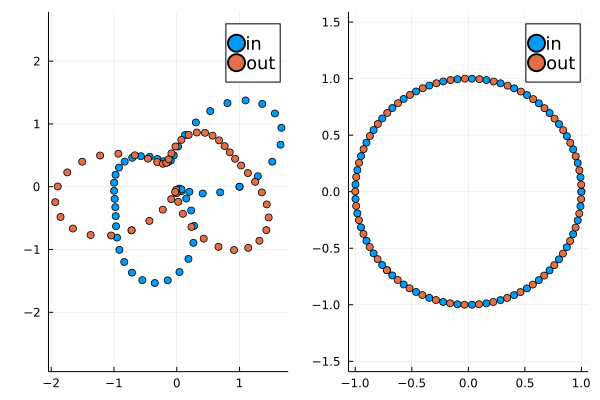

In [25]:
Aplot(U) # rotate/reflect back

# Putting it together

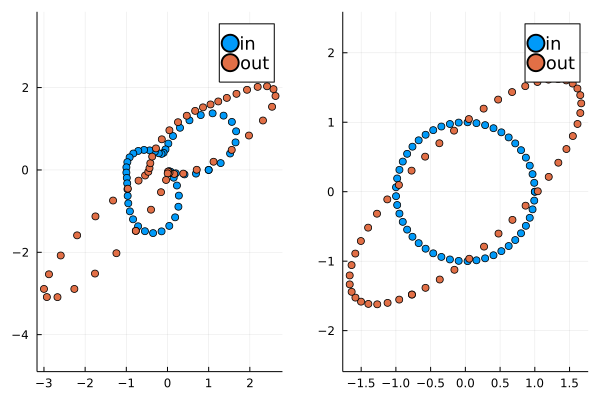

In [26]:
Aplot(U * diagm(S) * V')

# Observations

* The circle always maps to an ellipse
* The $U$ and $V$ factors may reflect even when $\det A > 0$